In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
def weibull_dist(lam, k):
    return ss.weibull_min(k, scale=lam)

In [5]:
lam = 3
k = 0.8
actual_dist = weibull_dist(lam, k)
actual_dist

In [6]:
data = actual_dist.rvs(10)
data

array([2.6468967 , 2.08780501, 0.41091982, 5.8958362 , 0.15168429,
       1.62809772, 0.01761427, 2.9159499 , 0.43015048, 1.00598553])

In [7]:
def make_uniform(qs, name=None, **options):
    pmf = Pmf(1.0, qs, **options)
    pmf.normalize()
    if name:
        pmf.index.name = name
    return pmf

In [10]:
lams = np.linspace(0.1, 10.1, 101)
prior_lam = make_uniform(lams, name='lambda')

In [11]:
ks = np.linspace(0.1, 5.1, 101)
prior_k = make_uniform(ks, name='k')

In [12]:
def make_joint(pmf1, pmf2):
    X, Y = np.meshgrid(pmf1, pmf2)
    return pd.DataFrame(X * Y, columns=pmf1.qs, index=pmf2.qs)

In [13]:
prior = make_joint(prior_lam, prior_k)

In [14]:
lam_mesh, k_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)

In [15]:
densities = weibull_dist(lam_mesh, k_mesh).pdf(data_mesh)
densities.shape

(101, 101, 10)

In [16]:
likelihood = densities.prod(axis=2)

In [17]:
def normalize(joint):
    prob_data = joint.to_numpy().sum()
    joint /= prob_data
    return prob_data

In [18]:
posterior = prior * likelihood
normalize(posterior)

4.750536750762876e-09

In [19]:
def update_weibull(prior, data):
    lam_mesh, k_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
    densities = weibull_dist(lam_mesh, k_mesh).pdf(data_mesh)
    likelihood = densities.prod(axis=2)

    posterior = prior * likelihood
    normalize(posterior)

    return posterior

In [20]:
posterior = update_weibull(prior, data)

In [21]:
def plot_contour(joint):
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.contour(joint.columns, joint.index, joint, linewidths=2)

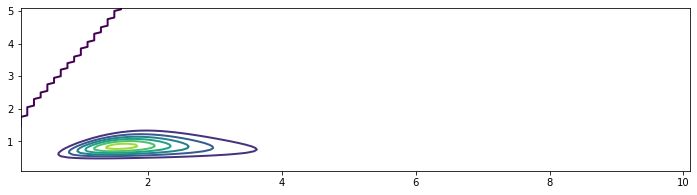

In [24]:
plot_contour(posterior)

In [25]:
start = np.random.uniform(0, 8, size=10)

In [26]:
duration = actual_dist.rvs(10)

In [28]:
d = dict(start=start, end=duration + start)
obs = pd.DataFrame(d).sort_values(by='start', ignore_index=True)
obs

,start,end
0,0.975285,1.468666
1,1.309885,7.048853
2,1.407133,2.158403
3,1.984548,3.129668
4,2.885727,4.868909
5,3.738080,4.337096
6,3.927806,10.807295
7,5.692360,17.166239
8,7.140368,7.973777
9,7.503355,19.022291


In [29]:
censored = obs['end'] > 8
censored

0    False
1    False
2    False
3    False
4    False
5    False
6     True
7     True
8    False
9     True
Name: end, dtype: bool

In [34]:
obs.loc[censored, 'end'] = 8
obs.loc[censored, 'status'] = 0

In [35]:
obs

,start,end,statues,status
0,0.975285,1.468666,NaN,NaN
1,1.309885,7.048853,NaN,NaN
2,1.407133,2.158403,NaN,NaN
3,1.984548,3.129668,NaN,NaN
4,2.885727,4.868909,NaN,NaN
5,3.738080,4.337096,NaN,NaN
6,3.927806,8.000000,0.0,0.0
7,5.692360,8.000000,0.0,0.0
8,7.140368,7.973777,NaN,NaN
9,7.503355,8.000000,0.0,0.0


In [36]:
def plot_lifelines(obs):
    for y, row in obs.iterrows():
        start = row['start']
        end = row['end']
        status = row['status']
        
        if status == 0:
            plt.hlines(y, start, end, color='C0')
        else:
            plt.hlines(y, start, end, color='C1')
            plt.plot(end, y, marker='o', color='C1')

    plt.gca().invert_yaxis()

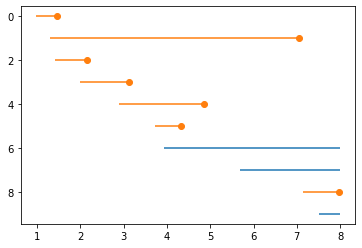

In [37]:
plot_lifelines(obs)

In [38]:
obs['T'] = obs['end'] - obs['start']

In [39]:
data1 = obs.loc[~censored, 'T']
data2 = obs.loc[censored, 'T']

In [40]:
posterior1 = update_weibull(prior, data1)

In [41]:
def update_weibull_incomplete(prior, data):
    lam_mesh, k_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
    probs = weibull_dist(lam_mesh, k_mesh).sf(data_mesh)
    likelihood = probs.prod(axis=2)

    posterior = prior * likelihood
    normalize(posterior)

    return posterior

In [44]:
posterior2 = update_weibull_incomplete(posterior1, data2)

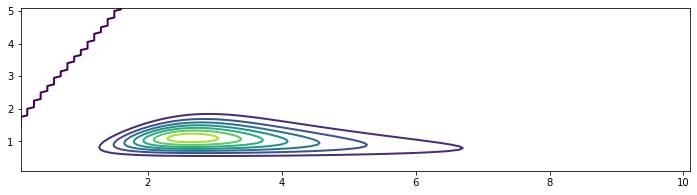

In [45]:
plot_contour(posterior2)

In [47]:
df = pd.read_csv(Path.cwd() / 'data' / 'lamps.csv')

In [48]:
pmf_bulb = Pmf(df['f'].to_numpy(), df['h'])
pmf_bulb.normalize()

50

In [49]:
lams = np.linspace(1000, 2000, 51)
prior_lam = make_uniform(lams, name='lambda')

In [50]:
ks = np.linspace(1, 10, 51)
prior_k = make_uniform(ks, name='k')

In [51]:
prior_bulb = make_joint(prior_lam, prior_k)

In [54]:
data_bulb = np.repeat(df['h'], df['f'])
data_bulb.shape

(50,)

In [56]:
posterior_bulb = update_weibull(prior_bulb, data_bulb)

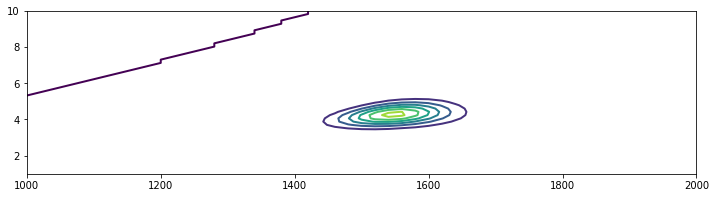

In [57]:
plot_contour(posterior_bulb)

In [58]:
lam_mesh, k_mesh = np.meshgrid(prior_bulb.columns, prior_bulb.index)

In [59]:
means = weibull_dist(lam_mesh, k_mesh).mean()

In [60]:
prod = means * posterior_bulb

In [62]:
prod.to_numpy().sum()

1412.7242774305005

In [63]:
def joint_weibull_mean(joint):
    lam_mesh, k_mesh = np.meshgrid(joint.columns, joint.index)
    means = weibull_dist(lam_mesh, k_mesh).mean()
    prod = means * joint
    return prod.to_numpy().sum()

In [64]:
lam = 1550
k = 4.25
t = 1000
prob_dead = weibull_dist(lam, k).cdf(t)
prob_dead

0.14381685899960547

In [65]:
def make_binomial(n, p):
    ks = np.arange(n + 1)
    ps = ss.binom.pmf(ks, n, p)
    return Pmf(ps, ks)

In [66]:
n = 100
p = prob_dead
dist_num_dead = make_binomial(n, p)

In [67]:
def make_mixture(pmf, pmf_seq):
    df = pd.DataFrame(pmf_seq).fillna(0).T
    df *= np.array(pmf)
    total = df.sum(axis=1)
    return Pmf(total)

In [68]:
posterior_series = posterior_bulb.stack()
posterior_series.head()

1.0  1000.0    8.146763e-25
     1020.0    1.210486e-24
     1040.0    1.738327e-24
     1060.0    2.418201e-24
     1080.0    3.265549e-24
dtype: float64

In [69]:
pmf_seq = []
for (k, lam) in posterior_series.index:
    prob_dead = weibull_dist(lam, k).cdf(t)
    pmf = make_binomial(n, prob_dead)
    pmf_seq.append(pmf)

In [70]:
post_pred = make_mixture(posterior_series, pmf_seq)